# Preparación de los Datos

Data disponible en Google Drive:
    https://drive.google.com/drive/folders/1oreZrtH77Iz2XgJu1qVBv5ZVTDG7hW0u?usp=sharing

### Importe de Bibliotecas

In [90]:
%matplotlib inline
import pyaudio
import wave
import time
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.simplefilter("ignore", DeprecationWarning)


### Filtrado de colas

In [91]:
def filter_audio(file_in, file_out, porcentaje):

    _format = pyaudio.paInt16
    _channels = 2
    _rate = 44100
    _chunk = 2048
    
    flag = True
    max_v = 2**16

    wf = wave.open(file_in, 'rb')
    audio = pyaudio.PyAudio()
    data = wf.readframes(_chunk)
    frames = []
    
    while len(data) > 0:
        flag = True

        data_num = np.fromstring(data,dtype=np.int16)

        data_num_l = data_num[0::2]
        data_num_r = data_num[1::2]

        porcentaje = int(porcentaje)
        max_num_l = np.abs(max_v)
        min_wall_l = max_num_l * porcentaje/100

        max_num_r = np.abs(max_v)
        min_wall_r = max_num_r * porcentaje/100

        for i in range (0, len(data_num_l)):
            if(flag):
                if(np.abs(data_num_l[i]) < min_wall_l):
                    flag = True
                else:
                    flag = False

        for i in range (0, len(data_num_r)):
              if(flag):
                if(np.abs(data_num_r[i]) < min_wall_r):
                    flag = True
                else:
                    flag = False

        if(flag):
            data_num[0::2] = 0
            data_num[1::2] = 0
        else:
            data_num[0::2] = data_num_l
            data_num[1::2] = data_num_r
            frames.append(data_num)

        data = wf.readframes(_chunk)
        audio.terminate()

    waveFile = wave.open(file_out, 'wb')
    waveFile.setnchannels(_channels)
    waveFile.setsampwidth(audio.get_sample_size(_format))
    waveFile.setframerate(_rate)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()
        
    print("------------------------------------------------------------------")
    print("Archivo Generado! Salida --> %s" % file_out)
    print("------------------------------------------------------------------")
    return

In [92]:
users = ["keyli_gonzalez", "betsabe_castillo", "wilmari_vielma", "gustavo_mejia", "junior_valera", "kevin_marquez"]
users

['keyli_gonzalez',
 'betsabe_castillo',
 'wilmari_vielma',
 'gustavo_mejia',
 'junior_valera',
 'kevin_marquez']

In [93]:
usernames = ["keyli Gonzalez", "Betsabe Castillo", "Wilmari Vielma", "Gustavo Mejia", "Junior Valera", "Kevin Marquez"]
usernames

['keyli Gonzalez',
 'Betsabe Castillo',
 'Wilmari Vielma',
 'Gustavo Mejia',
 'Junior Valera',
 'Kevin Marquez']

### Generación de espectros de frecuencias (longitud fija)

In [94]:
for i in range (0, len(users)):
    for j in range (1, 21):
        wav_out = "muestra/"+users[i]+"/f_sample_%d.wav" % j
        png_out = "muestra/"+users[i]+"/f_sample_%d.png" % j
        filter_audio("muestra/"+users[i]+"/sample_%d.wav" % j, wav_out, 15)
        !ffmpeg -y -i {wav_out} -lavfi showspectrumpic=s=960x540 {png_out}

------------------------------------------------------------------
Archivo Generado! Salida --> muestra/keyli_gonzalez/f_sample_1.wav
------------------------------------------------------------------
ffmpeg version 3.4.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7.3.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-avisynth --enable-avresample --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libass --enable-libbluray --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxv

In [95]:
for i in range (0, len(users)):
    for j in range (1, 21):
        png_in = "muestra/"+users[i]+"/f_sample_%d.png" % j
        png_out = "muestra/"+users[i]+"/rf_sample_%d.png" % j
        image = cv2.imread(png_in)
        
        
        ## Crop Image
        cropped = image[284:604, 116:1076]
        
        ## Resize Image
        r = 300.0 / cropped.shape[1]
        dim = (300, int(cropped.shape[0] * r))
        resized = cv2.resize(cropped, dim, interpolation = cv2.INTER_AREA)
        
        ## Save Image
        cv2.imwrite(png_out, resized)
        

In [96]:
data_images = []
label_images = []

for i in range (0, len(users)):
    for j in range (1, 21):
        png_in = "muestra/"+users[i]+"/rf_sample_%d.png" % j
        image = cv2.imread(png_in)
        
        b,g,r = cv2.split(image)       
        image = cv2.merge([r,g,b])
        image = np.einsum('ijk->kij', image)
        image.reshape(90000)
        data_images.append(image)  
        label_images.append(i)
    
        

arrrasd_img = np.array(data_images)
arrrasd_img = arrrasd_img.reshape(10800000//90000,90000)

pixel_name = []

for i in range (1, 90001):
    pixel_name.append("pixel_%d" % i)

print(arrrasd_img)

df_images = pd.DataFrame(data=arrrasd_img, columns=pixel_name)
df_images.insert(loc=0, column='label', value=label_images)
df_images.to_csv("./dataset.csv")
df_images

[[186 189 192 ...  42  50  60]
 [111 114 116 ...   5   9  14]
 [178 185 194 ...  44  59  77]
 ...
 [189 189 189 ...   3   2   1]
 [ 71  64  56 ...  23  38  60]
 [180 182 185 ...  67  89 102]]


,label,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_89991,pixel_89992,pixel_89993,pixel_89994,pixel_89995,pixel_89996,pixel_89997,pixel_89998,pixel_89999,pixel_90000
0,0,186,189,192,194,195,195,194,192,189,...,0,0,3,7,18,40,38,42,50,60
1,0,111,114,116,116,114,113,111,108,105,...,10,6,4,3,2,2,3,5,9,14
2,0,178,185,194,202,209,215,220,224,227,...,1,4,7,12,17,24,33,44,59,77
3,0,107,93,87,101,123,138,148,156,162,...,36,32,28,25,23,22,23,24,27,31
4,0,130,131,131,131,131,129,127,124,120,...,47,51,54,59,66,74,84,96,111,123
5,0,83,88,102,118,131,142,151,158,164,...,20,20,20,22,23,26,30,34,40,48
6,0,157,156,158,159,162,171,176,180,182,...,22,20,22,32,16,8,4,2,1,1
7,0,104,102,99,93,87,77,65,59,57,...,33,38,44,48,50,51,54,57,61,67
8,0,74,79,87,89,94,109,124,135,143,...,0,3,8,6,2,0,0,0,0,2
9,0,116,122,128,132,134,135,132,132,146,...,17,20,22,24,26,27,28,30,33,37


In [98]:
x_entrenamiento = df_images[df_images.columns[1:]].values
y_entrenamiento = df_images['label'].values
x_entrenamiento = x_entrenamiento.reshape(len(x_entrenamiento), 3, 100, 300)
y_entrenamiento = y_entrenamiento.reshape(len(y_entrenamiento), 1)

print(x_entrenamiento.shape)
print(y_entrenamiento.shape)

(120, 3, 100, 300)
(120, 1)


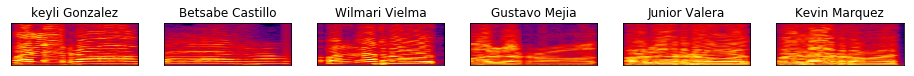

In [99]:
fig = plt.figure(figsize=(16,3))
for i in range(6):
    ax = fig.add_subplot(2, 6, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_entrenamiento[:]==i)[0]
    features_idx = x_entrenamiento[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    ax.set_title(usernames[i])
    plt.imshow(im)
plt.show()



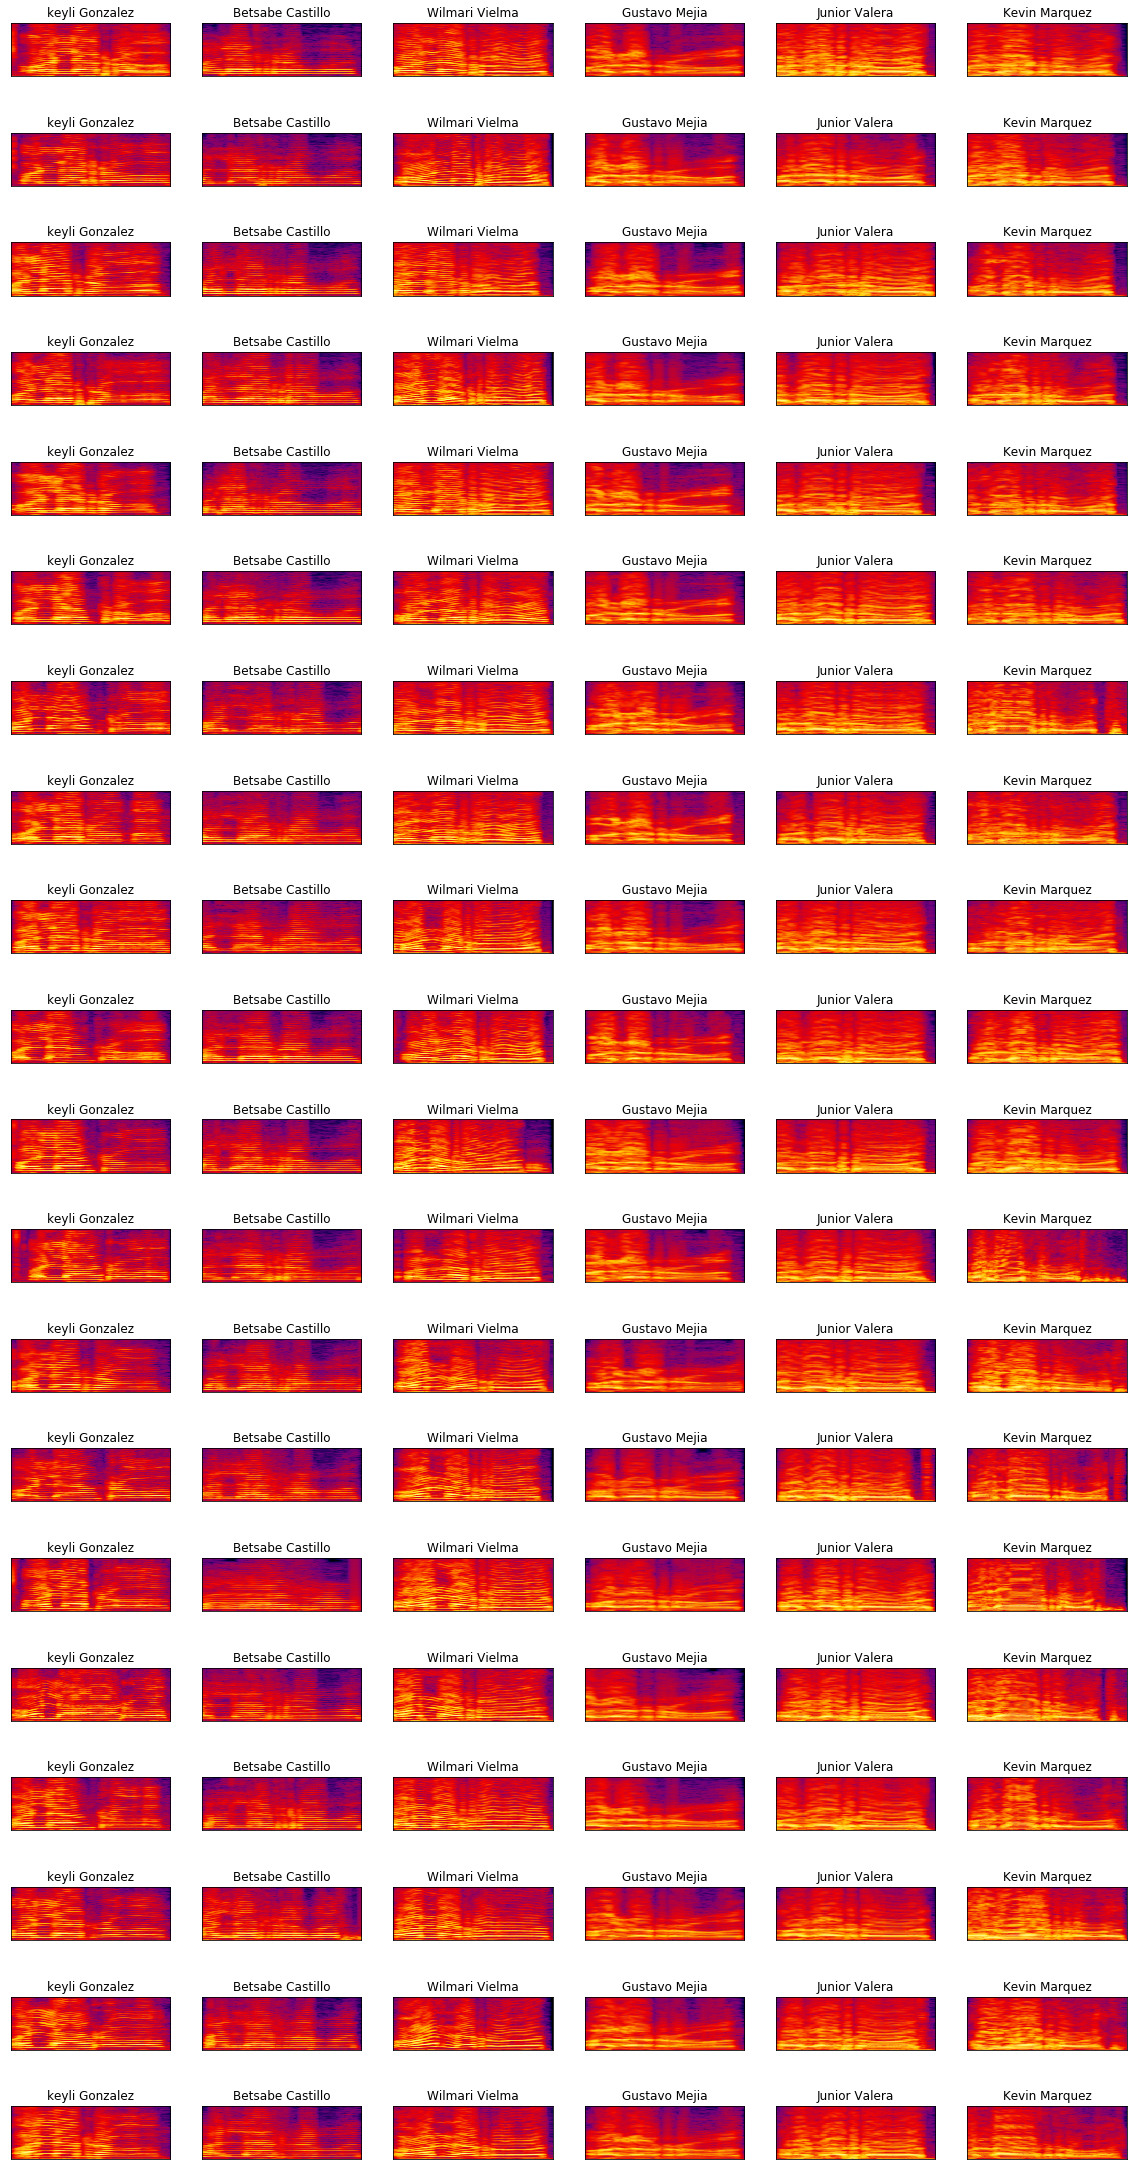

In [100]:
a1 = x_entrenamiento[0:20,::]
a2 = x_entrenamiento[20:40,::]
a3 = x_entrenamiento[40:60,::]
a4 = x_entrenamiento[60:80,::]
a5 = x_entrenamiento[80:100,::]
a6 = x_entrenamiento[100:120,::]

fig = plt.figure(figsize=(20,40))

j = 0;


for i in range(20):

    ax = fig.add_subplot(20, 6, 1 + j, xticks=[], yticks=[])
    im = np.transpose(a1[i,::],(1,2,0))
    ax.set_title(usernames[0])
    plt.imshow(im)
    
    j = j+1
    
    ax = fig.add_subplot(20, 6, 1 + j, xticks=[], yticks=[])
    im = np.transpose(a2[i,::],(1,2,0))
    ax.set_title(usernames[1])
    plt.imshow(im)
    
    j = j+1

    ax = fig.add_subplot(20, 6, 1 + j, xticks=[], yticks=[])
    im = np.transpose(a3[i,::],(1,2,0))
    ax.set_title(usernames[2])
    plt.imshow(im)
    
    j = j+1
       
    ax = fig.add_subplot(20, 6, 1 + j, xticks=[], yticks=[])
    im = np.transpose(a4[i,::],(1,2,0))
    ax.set_title(usernames[3])
    plt.imshow(im)
    
    j = j+1
    
    
    ax = fig.add_subplot(20, 6, 1 + j, xticks=[], yticks=[])
    im = np.transpose(a5[i,::],(1,2,0))
    ax.set_title(usernames[4])
    plt.imshow(im)
    
    j = j+1
    
    
    ax = fig.add_subplot(20, 6, 1 + j, xticks=[], yticks=[])
    im = np.transpose(a6[i,::],(1,2,0))
    ax.set_title(usernames[5])
    plt.imshow(im)
    
    j = j+1
    

plt.show()


